<a href="https://colab.research.google.com/github/wltjr1007/pnpxai/blob/main/tutorials/lear_workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Medical Image Classification with PnPXAI

In this notebook, we demonstrate the use of the PnPXAI library for explaining a ResNet-based image classification model on the ADNI (Alzheimer's Disease Neuroimaging Initiative) dataset.

**Contents:**
1. [Setup](#setup)
    - [Clone PnPXAI repository and install dependencies](#clone-install)
2. [Loading Data and Model](#data-model)
    - [Load ADNI Dataset](#load-data)
    - [Load Pre-trained ResNet Model](#load-model)
3. [Explanation Using PnPXAI](#explanation)
    - [Add the LEAR Explainer](#lear-explainer)
    - [Generate Explanations](#generate-explanations)
4. [Visualization](#visualization)
    - [Visualize Original Images and Explanations](#visualize-images)
5. [Evaluation of Explanations](#evaluation)
    - [MuFidelity](#mufidelity)
    - [Sensitivity](#sensitivity)
    - [Complexity](#complexity)

This example demonstrates how PnPXAI can be used to gain insights into the decision-making process of a medical image classification model, specifically for Alzheimer's disease classification.



## 1. Setup<a name="setup"></a>

First, we clone the PnPXAI repository and install the required dependencies.

In [ ]:
!git clone --quiet https://github.com/wltjr1007/pnpxai
!pip install -q -e /content/pnpxai && pip install -q datasets

import sys
sys.path.append('/content/pnpxai')

fatal: destination path 'pnpxai' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import Tensor


from transformers import AutoImageProcessor, ResNetForImageClassification, set_seed
from datasets import load_dataset

from pnpxai import AutoExplanationForImageClassification
from pnpxai.evaluator.metrics import MuFidelity, Sensitivity, Complexity

set_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_REP = "wltjr1007/MRI"
MODEL_REP = "evanrsl/resnet-Alzheimer"


## 2. Loading Data and Model<a name="data-model"></a>


### 2.1 Load ADNI Dataset<a name="load-data"></a>

In this step, we load the ADNI dataset from the `datasets` library, which will be used to train and evaluate the model.


### Preprocessing Steps
1. **Image Transformation**: All images are converted to RGB format and preprocessed using a pre-trained image processor (e.g., ResNet-specific).
2. **Normalization**: The pixel values are normalized using the mean and standard deviation provided by the pre-trained model configuration.

In [ ]:
def transform(examples):
    examples["pixel_values"] = [processor(images=img.convert("RGB"), return_tensors="pt")["pixel_values"].squeeze(0) for img in examples["image"]]
    examples["label"] = torch.tensor(examples["label"])
    del examples["image"]
    return examples

processor = AutoImageProcessor.from_pretrained(MODEL_REP)
dataset = load_dataset(DATA_REP)['test'].with_transform(transform)
num_classes = dataset.features["label"].num_classes
# loader = DataLoader(dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### ADNI Dataset

The **Alzheimer's Disease Neuroimaging Initiative (ADNI)** dataset is widely used for research on Alzheimer's disease (AD). It contains various types of data, including imaging data such as MRI, PET scans, and clinical assessments. This dataset enables classification and prediction of disease progression through machine learning models.

### Dataset Classes

The ADNI dataset is categorized into the following diagnostic labels:

- **Normal**: Indicates individuals with no signs of cognitive impairment or Alzheimer's disease.
- **MCI (Mild Cognitive Impairment)**:
  - **sMCI (Stable MCI)**: MCI cases where the condition does not progress to AD over a specified period.
  - **pMCI (Progressive MCI)**: MCI cases that eventually progress to AD.
- **AD (Alzheimer's Disease)**: Represents individuals clinically diagnosed with Alzheimer's disease.

Each class label corresponds to a numeric value in the dataset for ease of use in machine learning tasks.

## Dataset Source and Preprocessing

Please refer to the official [ADNI](https://adni.loni.usc.edu/) website for the original dataset.

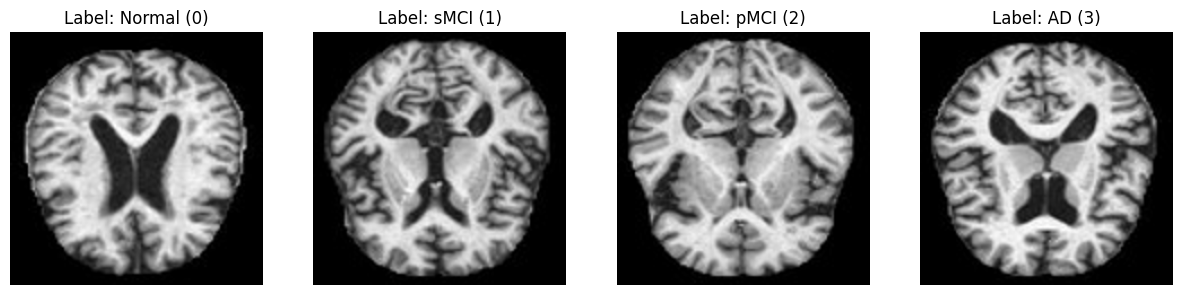

In [ ]:
img_to_np = lambda img: img.permute(1, 2, 0).cpu().detach().numpy()

def denormalize_image(inputs, mean=processor.image_mean, std=processor.image_std):
    res = inputs * torch.tensor(std, device=inputs.device)[:, None, None] + torch.tensor(mean, device=inputs.device)[:, None, None]
    return img_to_np(res)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

label_dict = {0: "Normal", 1: "sMCI", 2: "pMCI", 3: "AD"}

for i in range(4):
    label_idx = dataset[i]['label'].item()
    axes[i].imshow(denormalize_image(dataset[i]["pixel_values"]))
    axes[i].set_title(f"Label: {label_dict[label_idx]} ({label_idx})")
    axes[i].axis("off")

plt.show()


### 2.2 Load Pre-trained ResNet Model<a name="load-model"></a>

We load a pre-trained ResNet model for Alzheimer's disease classification. The model weights are sourced from the `transformers` library.

In [ ]:
class ResNetBase(ResNetForImageClassification):
    """
    PnPXai requires a Tensor output from the model.
    We create a custom model since ResNetForImageClassification outputs a tuple[Tensor] instead of a Tensor.
    """
    def forward(self, *args, **kwargs):
        return super().forward(*args, **kwargs)[0]

model = ResNetBase.from_pretrained(MODEL_REP, return_dict=False).to(device)

## 3. Explanation Using PnPXAI<a name="explanation"></a>

In [ ]:
expr = AutoExplanationForImageClassification(
    model=model,
    data=dataset,
    input_extractor=lambda batch: batch['pixel_values'].to(device),
    label_extractor=lambda batch: batch['label'].to(device),
    target_extractor=lambda outputs: outputs.argmax(-1).to(device),
    target_labels=False,  # target prediction if False
)

/content/pnpxai/pnpxai/evaluator/metrics/sensitivity.py:39: UserWarning: [Sensitivity] explainer is not provided. Please set explainer before evaluate.
  warnings.warn('[Sensitivity] explainer is not provided. Please set explainer before evaluate.')



### 3.1 Add the LEAR Explainer<a name="lear-explainer"></a>

We use the `LEAR` explainer from the PnPXAI library to generate explanations for our classification model.


> **Learn-Explain-Reinforce: Counterfactual Reasoning and Its Guidance to Reinforce an Alzheimer's Disease Diagnosis Model**<br>
> [Kwanseok Oh](https://scholar.google.co.kr/citations?user=EMYHaHUAAAAJ&hl=ko)<sup>1,\*</sup>, [Jee Seok Yoon](https://scholar.google.co.kr/citations?user=YjaJ5qQAAAAJ&hl=ko)<sup>2,\*</sup>, and [Heung-Il Suk](https://scholar.google.co.kr/citations?user=dl_oZLwAAAAJ&hl=ko)<sup>1, 2</sup><br/>
> (<sup>1</sup>Department of Artificial Intelligence, Korea University) <br/>
> (<sup>2</sup>Department of Brain and Cognitive Engineering, Korea University) <br/>
> (* indicates equal contribution) <br/>
> Official Version: https://ieeexplore.ieee.org/document/9854196 <br/>
> Published in IEEE Transactions on Pattern Analysis and Machine Intelligence (2021 JCR-IF: 24.314, COMPUTER SCIENCE & ARTIFICIAL INTELLIGENCE: 2/144)

- We propose a novel learn-explain-reinforce framework that integrates the following tasks: (1) training a diagnostic model, (2) explaining a diagnostic model's output, and (3) reinforcing the diagnostic model based on the explanation systematically.
- To the best of our knowledge, this work is the first that exploits an explanation output to improve the generalization of a diagnostic model reciprocally.
- In regard to explanation, we propose a GAN-based method to produce multi-way counterfactual maps that can provide a more precise explanation, accounting for severity and/or progression of AD.

![Group 2896 (3)](https://user-images.githubusercontent.com/57162425/141603646-f714edb2-cc01-4b22-80df-056da791947c.png)


### How LEAR’s Loss Functions Shape Its Results
1. **$\mathscr{L}_{\text{map}}$: Sparsity and Relevance**
   - Encourages the counterfactual map to focus only on critical regions (e.g., hippocampus, ventricles) necessary for the transformation.
   - Results in clean and targeted explanations, avoiding the scattered and noisy patterns of other methods.

2. **$\mathscr{L}_{\text{cls}}$: Target-Specific Transformations**
   - Ensures that the highlighted regions directly relate to the target condition, providing accurate and meaningful explanations.

3. **$\mathscr{L}_{\text{adv}}$: Plausibility**
   - Enforces the realism of the counterfactual map, ensuring that the transformed image remains anatomically consistent.

4. **$\mathscr{L}_{\text{cyc}}$: Consistency**
   - Guarantees that the transformation between Normal and the target condition is reversible, leading to logical and progressive changes across rows.

5. **$\mathscr{L}_{\text{tv}}$: Smoothness**
   - Minimizes abrupt changes in the counterfactual map, contributing to the clean and noise-free explanations seen in LEAR.

In summary, LEAR’s loss functions collectively enable it to produce sparse, targeted, and biologically meaningful visual explanations, setting it apart from traditional methods in both precision and interpretability.

In [ ]:
from pnpxai.explainers import LEAR

lear_model = LEAR(model=model)
expr.manager.add_explainer(lear_model)

13


### 3.2 Generate Explanations<a name="generate-explanations"></a>

We extract explanations for a sample of images from the dataset using the `LEAR` explainer.


In [ ]:
data_idx = 0

data_sample = dataset[data_idx]
inputs = data_sample['pixel_values'].to(device)[None]
labels = data_sample['label'].to(device)[None]

explanations = {}
postprocessors = {}
for exp_id in range(len(expr.manager.explainers)):
    explainer = expr.manager.get_explainer_by_id(exp_id)
    postprocessor = expr.manager.get_postprocessor_by_id(exp_id)
    try:
        name = explainer.__class__.__name__
        explanations[name] = [explainer.attribute(inputs, torch.full_like(labels, lbl)) for lbl in range(num_classes)]
        postprocessors[name] = postprocessor
    except:
        print("Not Implemented", name)

Not Implemented GradCam


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Not Implemented GuidedGradCam


/content/pnpxai/pnpxai/explainers/lrp.py:341: UserWarning: Your model cannot be traced by torch.fx.symbolic_trace.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.335e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.181e-01, tolerance: 1.137e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the nu


## 4. Visualization<a name="visualization"></a>


### Results (presented in the paper)

>Visual explanation comparison between XAI methods
![img](https://user-images.githubusercontent.com/57162425/141603345-abdf11e0-f7bf-4ecf-979e-f1604cd27c2c.jpg)

> Example of counterfactual map conditioned on interpolated target labels

<img src=https://user-images.githubusercontent.com/57162425/141603337-4951d4d6-8237-4fc1-80dd-8c87f7dd9d18.png alt="drawing" width="500"/>


### 4.1 Visualize Original Images and Explanations<a name="visualize-images"></a>

In this section, we visualize the original images alongside the explanations generated by the `LEAR` explainer.

### Key Observations for LEAR
The LEAR framework demonstrates the following key properties, attributed to its loss function design:

1. **Sparsity and Specificity**:
   - LEAR highlights only the most critical regions necessary for transforming the input condition (Normal) into the target condition (e.g., sMCI, pMCI, AD).
   - **Key Loss**: The counterfactual map regularization loss ($ \mathscr{L}_{\text{map}} $) ensures sparsity by suppressing irrelevant regions using $ \ell_1 $- and $ \ell_2 $-norms.

2. **Target-Specific Localization**:
   - LEAR focuses on disease-relevant regions, such as early hippocampal changes in sMCI and global atrophy in AD.
   - **Key Loss**: The classification loss ($ \mathscr{L}_{\text{cls}} $) ensures counterfactual maps transform the input toward the target label, emphasizing disease-specific regions.

3. **Fine-Grained Detailing**:
   - LEAR avoids blurry or noisy regions, producing sharper, more precise explanations compared to methods like VarGrad or Lime.
   - **Key Loss**: The adversarial loss ($ \mathscr{L}_{\text{adv}}^{\mathscr{G}} $) maintains anatomical plausibility and realism in the maps.

4. **Consistency Across Targets**:
   - LEAR produces smooth and logical transitions in counterfactual maps (e.g., sMCI → pMCI → AD), aligning with disease progression.
   - **Key Loss**: The cycle consistency loss ($ \mathscr{L}_{\text{cyc}} $) enforces reversible and coherent transformations between conditions.

5. **Robustness to Artifacts**:
   - LEAR avoids highlighting irrelevant regions (e.g., brain edges), ensuring only biologically meaningful areas are emphasized.
   - **Key Loss**: The total variation loss ($ \mathscr{L}_{\text{tv}} $) reduces abrupt or unnatural changes, improving smoothness and focus.

6. **No Changes for "Normal" Label**:
   - LEAR generates minimal changes for Normal inputs, reflecting logical consistency as no transformation is needed when the input aligns with the target label.

7. **Progressive Disease Representation (sMCI → pMCI → AD)**:
   - Counterfactual maps reveal increasingly pronounced changes with disease progression:
     - **sMCI**: Highlights subtle early changes (e.g., slight hippocampal atrophy).
     - **pMCI**: Expands to more pronounced regions of atrophy.
     - **AD**: Strongly emphasizes regions like the hippocampus, cortex, and ventricles, reflecting advanced degeneration.

8. **Gradual Transformation**:
   - LEAR effectively captures smooth and biologically consistent transitions across disease stages, highlighting its ability to model progressive changes.

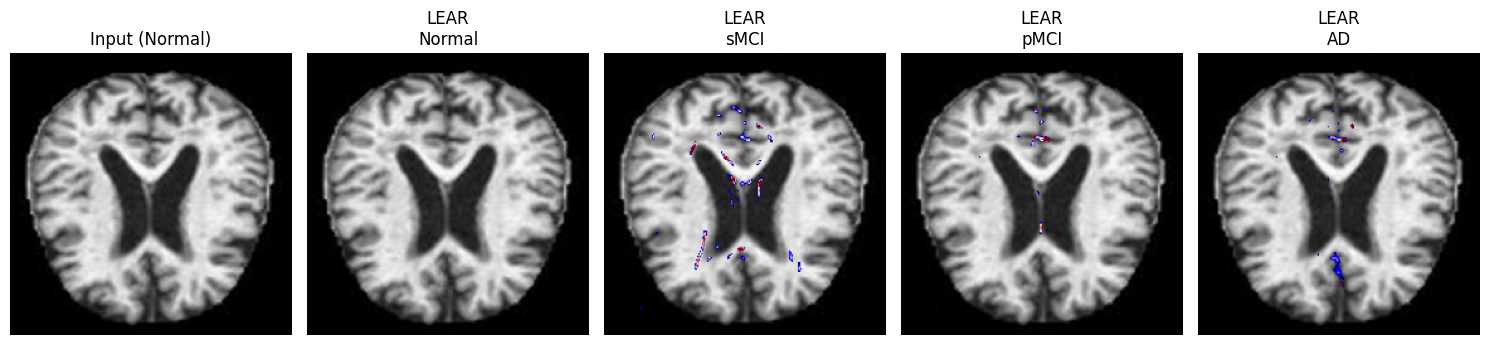

In [ ]:
fig, axes = plt.subplots(1, num_classes + 1, figsize=(15, 5))

# Display the input image
base_image = denormalize_image(inputs[0])
axes[0].imshow(base_image)
axes[0].axis("off")
axes[0].set_title(f"Input ({label_dict[labels[0].item()]})")

processed_attr = []
# Display explanations
for lbl in range(num_classes):
    attr = explanations["LEAR"]
    processed_attr += [postprocessors["LEAR"](attr[lbl])[0].cpu().detach().numpy()]
processed_attr = np.array(processed_attr)

# Create an overlay of the processed_attr on the input
overlay = plt.cm.seismic(processed_attr)
mask = (processed_attr >= -0.1) & (processed_attr <= 0.1)
overlay[mask,..., -1] = 0.

for lbl in range(num_classes):
    axes[lbl + 1].imshow(base_image)
    axes[lbl + 1].imshow(overlay[lbl])
    axes[lbl + 1].axis("off")
    axes[lbl + 1].set_title(f"{name}\n{label_dict[lbl]}")

plt.tight_layout()
plt.savefig("ADNI_LEAR.png", dpi=600)
plt.show()

### Comparison with Other Methods
- **Gradient-Based Methods**:
  These methods (e.g., Gradient, Gradient × Input) often highlight noisy and dispersed regions, lacking the specificity and disease relevance seen in LEAR. They are susceptible to vanishing gradients and focus on shallow features.
- **SHAP and Lime**:
  These methods sometimes capture relevant regions but suffer from over-generalization and include extraneous attributions (e.g., Lime’s scattered patterns in the AD row).
- **SmoothGrad and VarGrad**:
  While these methods reduce noise compared to raw gradient methods, they still struggle to provide fine-grained or localized attributions. Their explanations often highlight broader, less specific areas of the brain, as seen in the diffuse patterns across all rows.


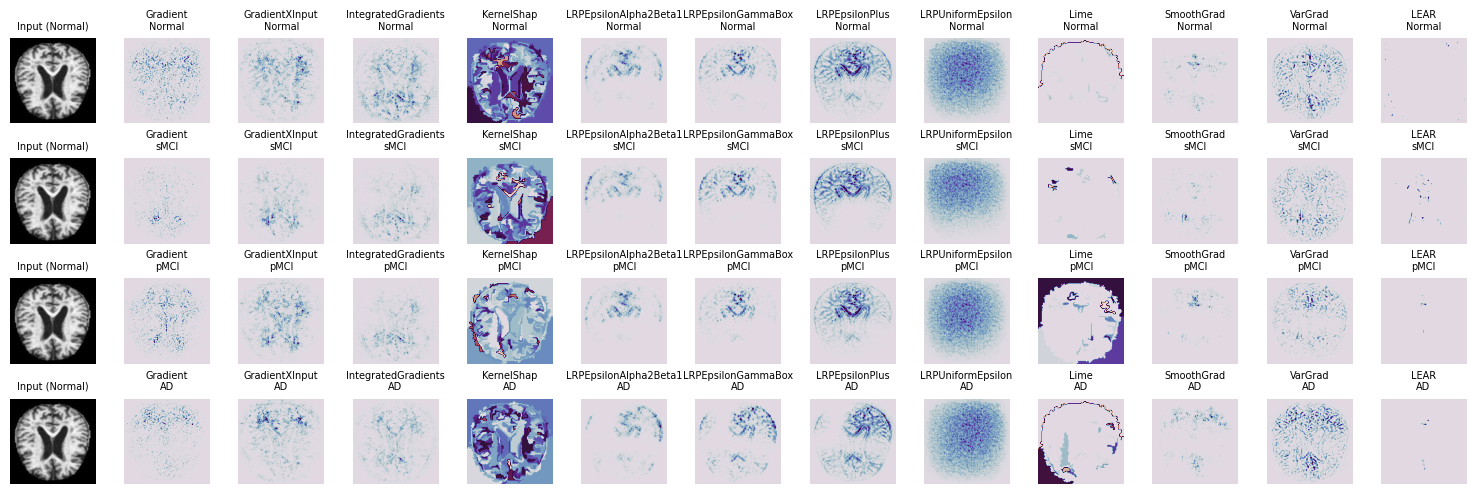

In [ ]:
ncols = len(explanations) + 1
fig, axes = plt.subplots(num_classes, ncols, figsize=(15, 5))

for lbl in range(num_classes):
    # Original image
    img = denormalize_image(inputs[0])
    axes[lbl, 0].imshow(img)
    axes[lbl, 0].axis("off")
    axes[lbl, 0].set_title(f"Input ({label_dict[labels[0].item()]})", fontsize=7)

    # Overlay explanations
    for idx, (name, attr) in enumerate(explanations.items(), start=1):
        processed_attr = postprocessors[name](attr[lbl])[0].cpu().detach().numpy()
        axes[lbl, idx].imshow(processed_attr, cmap="twilight")
        axes[lbl, idx].axis("off")
        axes[lbl, idx].set_title(f"{name}\n{label_dict[lbl]}", fontsize=7)

plt.tight_layout()
plt.savefig("ADNI_ALL.png", dpi=600)
plt.show()


## 5. Evaluation of Explanations<a name="evaluation"></a>

### 5.1 MuFidelity<a name="mufidelity"></a>

We use `MuFidelity` to evaluate the correctness of the explanations based on input perturbations.

### 5.2 Sensitivity<a name="sensitivity"></a>

`Sensitivity` measures the robustness of the explanations against input perturbations.

### 5.3 Complexity<a name="complexity"></a>

The `Complexity` metric is used to evaluate the compactness of the explanations.


In [ ]:
from pnpxai.evaluator.metrics import MuFidelity, Sensitivity, Complexity

# Initialize metrics
mufd = MuFidelity(
    model=model,
    explainer=None,  # Can set explainer here if desired
    n_perturb=150,  # Correct parameter name
    noise_scale=0.2,  # Noise scale for perturbations
    batch_size=32,  # Batch size for evaluation
    grid_size=9,  # Perturbation grid size
    baseline=0.0  # Baseline value for masking
)

sens = Sensitivity(
    model=model,
    explainer=lear_model,  # Can set explainer here if desired
    n_iter=10,  # Number of iterations
    epsilon=0.2  # Magnitude of random uniform noise
)

cmpx = Complexity(
    model=model,
    explainer=None,  # Can set explainer here if desired
    n_bins=10  # Number of bins for histogram computation
)

# Example metric evaluations
mufd_score = mufd.evaluate(inputs=inputs, targets=labels, attributions=explanations["LEAR"][0])
sens_score = sens.evaluate(inputs=inputs, targets=labels, attributions=explanations["LEAR"][0])
cmpx_score = cmpx.evaluate(inputs=inputs, targets=labels, attributions=explanations["LEAR"][0])

print("MuFidelity:", mufd_score.mean().item())
print("Sensitivity:", sens_score.mean().item())
print("Complexity:", cmpx_score.mean().item())

MuFidelity: 0.07203342370772035
Sensitivity: 1.3774467706680298
Complexity: 0.05159780031836282


MuFidelity: 0.07203342370772035

Sensitivity: 1.3774467706680298

Complexity: 0.05159780031836282